In [1]:
''' In this notebook I test three integration methods (Euler-Cromer, Velocity Verlet, RK4) to see which gives me the
best orbit. By checking the Angular Momentum, Total Energy, and magnitude of the Laplace-Runge-Lenz vector for the orbits
given by each method, I choose one method to use, whichever gives the closest to a straight, flat line. '''

''' All of this is done in polar coordinates for the motion of a planet around a motionless Sun at the center. '''

# Useful Python Packages
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Make plots larger
plt.rcParams['figure.dpi']=100
plt.rcParams['figure.facecolor']='w'

### Defining Constants

In [3]:
G = 6.675e-11 #Gravitaional constant
M = 2.0e+30 #Mass of the Sun
m = 0.33e+24 #Mass of Mercury
c = 3.0e+8 #Speed of Light

x0 = 69.8e+9 #Mercury aphelion
vy0 = 38.9e+3 #Mercury minimum orbital velocity (therefore velocity at aphelion)

a = 57.9e+9 #Mercury orbital semi-major axis

In [4]:
def magni(x):
    ''' Calculate magnitude of each vector in an array of vectors [[x0, y0], ..., [xn, yn]] '''
    return np.sqrt(x[:,0]**2 + x[:,1]**2)

### Acceleration Functions

In [5]:
def a_r_N(rd, r, l):
    ''' Calculate radial acceleration in Newtonian Gravity '''
    return -G*M/r**2 + l**2/r**3

def a_r_E(rd, r, l):
    ''' Calculate radial acceleration with the GR correction term '''
    return -G*M/r**2 - 3*G*M*(l**2)/((c**2)*(r**4)) + l**2/r**3

def a_theta(rd, r, l):
    ''' Calculate angular acceleration '''
    return -2*l*rd/r**3

### Integration Functions

In [6]:
def euler(exp, yNo, a_r):
    '''
    Simulate Mercury's orbit using the Euler-Cromer method
    '''
    
    dt = 10**exp #Time step
    finalT = 365.25*86400*yNo #No. of Earth years to simulate
    N = int(finalT/dt)
    
    t = np.zeros(N+1, float) #Time
    r = np.zeros(N+1, float) #Radial position
    rd = np.zeros(N+1, float) #Radial velocity
    theta = np.zeros(N+1, float) #Angular position
    thetad = np.zeros(N+1, float) #Angular velocity
    l = np.zeros(N+1, float) #Angular momentum per unit mass

    r[0] = x0
    rd[0] = 0.0
    theta[0] = 0.0
    thetad[0] = vy0/x0
    l[0] = r[0]**2*thetad[0]
    
    for i in range(1, N+1):
        t[i] = t[i-1] + dt
        
        r[i] = r[i-1] + dt*rd[i-1]
        rd[i] = rd[i-1] + dt*a_r(rd[i-1], r[i], l[i-1])

        theta[i] = theta[i-1] + dt*thetad[i-1]       
        thetad[i] = thetad[i-1] + dt*a_theta(rd[i], r[i], l[i-1])
        
        l[i] = r[i]**2*thetad[i]
            
    return r, theta, rd, thetad, t

In [7]:
def velverlet(exp, yNo, a_r):
    '''
    Simulate Mercury's orbit using the Velocity Verlet method
    '''
    
    dt = 10**exp #Time step
    finalT = 365.25*86400*yNo #No. of Earth years to simulate
    N = int(finalT/dt)
    
    t = np.zeros(N+1, float) #Time
    r = np.zeros(N+1, float) #Radial position
    rd = np.zeros(N+1, float) #Radial velocity
    theta = np.zeros(N+1, float) #Angular position
    thetad = np.zeros(N+1, float) #Angular velocity
    l = np.zeros(N+1, float) #Angular momentum per unit mass

    r[0] = x0
    rd[0] = 0.0
    theta[0] = 0.0
    thetad[0] = vy0/x0
    l[0] = r[0]**2*thetad[0]
    
    for i in range(1, N+1):
        t[i] = t[i-1] + dt
        
        drhalf = rd[i-1] + 0.5*dt*a_r(rd[i-1], r[i-1], l[i-1])
        dthetahalf = thetad[i-1] + 0.5*dt*a_theta(rd[i-1], r[i-1], l[i-1])
        
        r[i] = r[i-1] + dt*drhalf
        rd[i] = drhalf + 0.5*dt*a_r(rd[i-1], r[i], l[i-1])

        theta[i] = theta[i-1] + dt*dthetahalf        
        thetad[i] = dthetahalf + 0.5*dt*a_theta(rd[i], r[i], l[i-1])

        l[i] = r[i]**2*thetad[i]

    return r, theta, rd, thetad, t

In [8]:
def rk4r(dt, a_r, r, rd, l, i):
    '''
    Calculate the radial position and velocity at a particular time step.
    Angular position and velocity are updated directly in the RK4 function, as the formula here simplifies tremendously.
    '''
    
    kr1 = rd[i-1]
    kv1 = a_r(rd[i-1], r[i-1], l[i-1])
    
    kr2 = rd[i-1] + kv1*dt/2
    kv2 = a_r(rd[i-1] + kv1*dt/2, r[i-1] + kr1*dt/2, l[i-1])
    
    kr3 = rd[i-1] + kv2*dt/2
    kv3 = a_r(rd[i-1] + kv2*dt/2, r[i-1] + kr2*dt/2, l[i-1])
    
    kr4 = rd[i-1] + kv3*dt
    kv4 = a_r(rd[i-1] + kv3*dt, r[i-1] + kr3*dt, l[i-1])
    
    x = r[i-1] + dt*(kr1 + 2*kr2 + 2*kr3 + kr4)/6
    v = rd[i-1] + dt*(kv1 + 2*kv2 + 2*kv3 + kv4)/6
    
    return x, v

def rk4(exp, yNo, a_r):
    '''
    Simulate Mercury's orbit using the Runge-Kutta 4 method.
    '''
    
    dt = 10**exp #Time step
    finalT = 365.25*86400*yNo #No. of Earth years to simulate
    N = int(finalT/dt)
    
    t = np.zeros(N+1, float) #Time
    r = np.zeros(N+1, float) #Radial position
    rd = np.zeros(N+1, float) #Radial velocity
    theta = np.zeros(N+1, float) #Angular position
    thetad = np.zeros(N+1, float) #Angular velocity
    l = np.zeros(N+1, float) #Angular momentum per unit mass

    r[0] = x0
    rd[0] = 0.0
    theta[0] = 0.0
    thetad[0] = vy0/x0
    l[0] = r[0]**2*thetad[0]
    
    for i in range(1, N+1):
        t[i] = t[i-1] + dt
        
        r[i], rd[i] = rk4r(dt, a_r, r, rd, l, i)
        
        theta[i] = theta[i-1] + dt*thetad[i-1] + 0.5*dt**2*a_theta(rd[i], r[i], l[i-1])
        thetad[i] = thetad[i-1] + dt*a_theta(rd[i], r[i], l[i-1])

        l[i] = r[i]**2*thetad[i]

    return r, theta, rd, thetad, t

### Energy

In [9]:
def ener(r, rd, theta, thetad):
    ''' Returns the energy of Mercury at each time step '''
    return -G*M*m/r + 0.5*m*(rd**2 + r**2*thetad**2)

### Orbital Details

In [10]:
rE, thE, rdE, thdE, tE = euler(3, 10, a_r_N) #Euler-Cromer

In [11]:
rV, thV, rdV, thdV, tV = velverlet(3, 10, a_r_N) #Velocity Verlet

In [12]:
rR, thR, rdR, thdR, tR = rk4(3, 10, a_r_N) #Runge-Kutta 4

In [13]:
#Energy for each method
eE = ener(rE, rdE, thE, thdE)
eV = ener(rV, rdV, thV, thdV)
eR = ener(rR, rdR, thR, thdR)

### Graphs

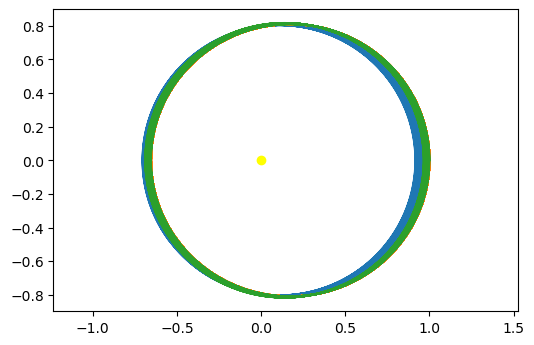

In [14]:
#Orbits obtained from each algorithm

plt.scatter(0,0, color = "yellow")
plt.plot(rE*np.cos(thE)/x0, rE*np.sin(thE)/x0)
plt.plot(rV*np.cos(thV)/x0, rV*np.sin(thV)/x0)
plt.plot(rR*np.cos(thR)/x0, rR*np.sin(thR)/x0)
plt.axis("equal")
plt.show()

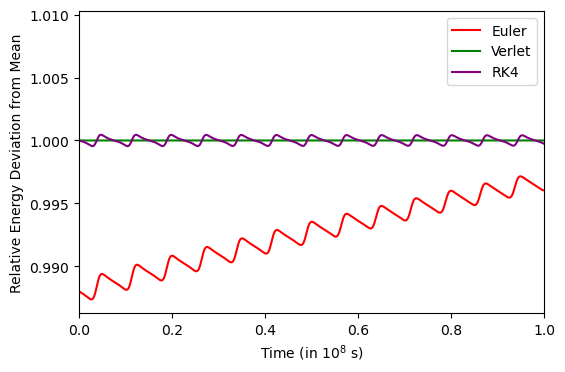

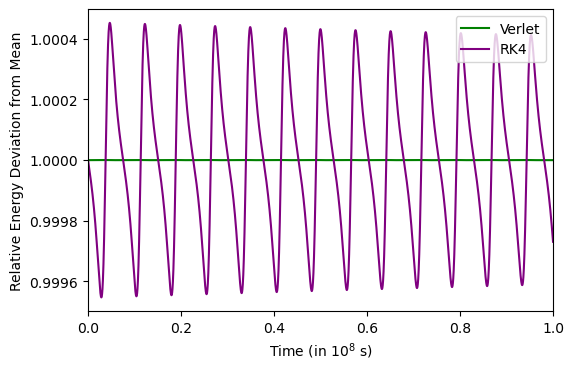

In [15]:
#Checking relative deviation of energy from the mean value, for Euler, Verlet, and RK4
plt.plot(tE/1e8, eE/np.mean(eE), color='red')
plt.plot(tV/1e8, eV/np.mean(eV), color='green')
plt.plot(tR/1e8, eR/np.mean(eR), color='purple')
plt.xlim(0,1) #Zooms in
plt.xlabel('Time (in 10$^8$ s)')
plt.ylabel('Relative Energy Deviation from Mean')
plt.legend(['Euler', 'Verlet', 'RK4'])
plt.show()

#Checking relative deviation of energy from the mean value, for Verlet and RK4
plt.plot(tV/1e8, eV/np.mean(eV), color='green')
plt.plot(tR/1e8, eR/np.mean(eR), color='purple')
plt.xlim(0,1) #Zooms in
plt.xlabel('Time (in 10$^8$ s)')
plt.ylabel('Relative Energy Deviation from Mean')
plt.legend(['Verlet', 'RK4'], loc = 'upper right')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.show()